fatal: destination path 'neurogym' already exists and is not an empty directory.
/content/neurogym/neurogym
Obtaining file:///content/neurogym/neurogym
ERROR: file:///content/neurogym/neurogym does not appear to be a Python project: neither 'setup.py' nor 'pyproject.toml' found.
Approx steps per trial (DMS): 160
Using seq_len (DMS) = 180
Input size (DMS): 3
Output size (DMS): 3
Inputs shape (DMS) (SeqLen, Batch, Dim): (180, 16, 3)
Targets shape (DMS) (SeqLen, Batch): (180, 16)
Baseline net (DMS):
 RNNNet(
  (rnn): LeakyRNN(
    (input2h): Linear(in_features=3, out_features=128, bias=True)
    (h2h): Linear(in_features=128, out_features=128, bias=True)
  )
  (fc): Linear(in_features=128, out_features=3, bias=True)
)
Training Baseline LeakyRNN (DMS) on DelayMatchSample-v0...


/usr/local/lib/python3.12/dist-packages/gymnasium/envs/registration.py:481: UserWarning: WARN: The environment creator metadata doesn't include `render_modes`, contains: ['paper_link', 'paper_name', 'tags']
  logger.warn(
/usr/local/lib/python3.12/dist-packages/gymnasium/core.py:311: UserWarning: WARN: env.seed to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.seed` for environment variables or `env.get_wrapper_attr('seed')` that will search the reminding wrappers.
  logger.warn(
/usr/local/lib/python3.12/dist-packages/gymnasium/core.py:311: UserWarning: WARN: env.new_trial to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.new_trial` for environment variables or `env.get_wrapper_attr('new_trial')` that will search the reminding wrappers.
  logger.warn(
/usr/local/lib/python3.12/dist-packages/gymnasium/core.py:311: UserWarning: WARN: e

[Baseline LeakyRNN (DMS)] step  100 | loss 0.7395 | time 7.9s
[Baseline LeakyRNN (DMS)] step  200 | loss 0.7037 | time 14.9s
[Baseline LeakyRNN (DMS)] step  300 | loss 0.7030 | time 22.8s
[Baseline LeakyRNN (DMS)] step  400 | loss 0.7005 | time 30.2s
[Baseline LeakyRNN (DMS)] step  500 | loss 0.7017 | time 37.7s
[Baseline LeakyRNN (DMS)] step  600 | loss 0.7016 | time 45.6s
[Baseline LeakyRNN (DMS)] step  700 | loss 0.6977 | time 52.6s
[Baseline LeakyRNN (DMS)] step  800 | loss 0.6967 | time 60.7s
[Baseline LeakyRNN (DMS)] step  900 | loss 0.6963 | time 67.8s
[Baseline LeakyRNN (DMS)] step 1000 | loss 0.6981 | time 75.6s
[Baseline LeakyRNN (DMS)] step 1100 | loss 0.6953 | time 83.8s
[Baseline LeakyRNN (DMS)] step 1200 | loss 0.6958 | time 91.8s
[Baseline LeakyRNN (DMS)] step 1300 | loss 0.6988 | time 99.9s
[Baseline LeakyRNN (DMS)] step 1400 | loss 0.6967 | time 107.9s
[Baseline LeakyRNN (DMS)] step 1500 | loss 0.6951 | time 115.8s
[Baseline LeakyRNN (DMS)] step 1600 | loss 0.6963 | ti

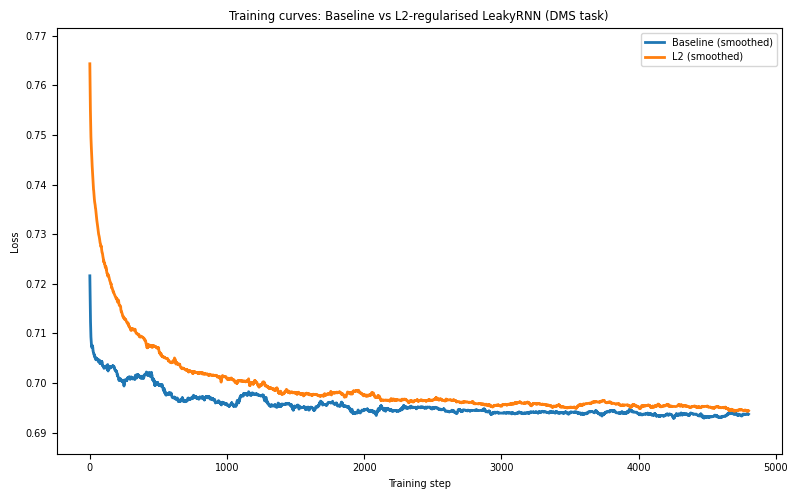

Task 2c (DMS) Baseline trial accuracy: 0.48
Task 2c (DMS) L2-regularised trial accuracy: 0.495


In [ ]:

!pip install gym
!git clone https://github.com/gyyang/neurogym.git
%cd neurogym/
!pip install -e .

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import time
import neurogym as ngym
import math
import random
from torch.nn import functional as F


def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

SEED = 0
set_seed(SEED)

task_name = 'DelayMatchSample-v0'

dms_timing = {
    'fixation': 300,
    'sample':   500,
    'delay':    1000,
    'test':     500,
    'decision': 900,
}

kwargs = {'dt': 20, 'timing': dms_timing}

trial_ms = sum(dms_timing.values())
dt = kwargs['dt']
trial_steps = math.ceil(trial_ms / dt)
print("Approx steps per trial (DMS):", trial_steps)

seq_len = trial_steps + 20
print("Using seq_len (DMS) =", seq_len)

batch_size = 16

def make_dataset_and_env_dms(seed):
    set_seed(seed)
    ds = ngym.Dataset(task_name, env_kwargs=kwargs,
                      batch_size=batch_size, seq_len=seq_len)
    env = ds.env
    try:
        env.seed(seed)
    except Exception:
        pass
    return ds, env

baseline_dataset_dms, env_dms = make_dataset_and_env_dms(SEED)
l2_dataset_dms, _             = make_dataset_and_env_dms(SEED)

input_size_dms = env_dms.observation_space.shape[0]
output_size_dms = env_dms.action_space.n

print("Input size (DMS):", input_size_dms)
print("Output size (DMS):", output_size_dms)


inputs_np, targets_np = baseline_dataset_dms()
print('Inputs shape (DMS) (SeqLen, Batch, Dim):', inputs_np.shape)
print('Targets shape (DMS) (SeqLen, Batch):', targets_np.shape)


class LeakyRNN(nn.Module):

    def __init__(self, input_size, hidden_size, dt=None, **kwargs):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.tau = 100

        if dt is None:
            alpha = 1.0
        else:
            alpha = dt / self.tau
        self.alpha = alpha

        self.input2h = nn.Linear(input_size, hidden_size)
        self.h2h = nn.Linear(hidden_size, hidden_size)

    def init_hidden(self, input_shape):
        batch_size = input_shape[1]
        return torch.zeros(batch_size, self.hidden_size)

    def recurrence(self, input, hidden):

        h_new = torch.relu(self.input2h(input) + self.h2h(hidden))
        h_new = hidden * (1 - self.alpha) + h_new * self.alpha
        return h_new

    def forward(self, input, hidden=None):
        if hidden is None:
            hidden = self.init_hidden(input.shape).to(input.device)

        outputs = []
        for t in range(input.size(0)):
            hidden = self.recurrence(input[t], hidden)
            outputs.append(hidden)

        outputs = torch.stack(outputs, dim=0)
        return outputs, hidden


class RNNNet(nn.Module):

    def __init__(self, input_size, hidden_size, output_size, **kwargs):
        super().__init__()
        self.rnn = LeakyRNN(input_size, hidden_size, **kwargs)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        rnn_output, _ = self.rnn(x)
        out = self.fc(rnn_output)
        return out, rnn_output


def train_model(net, dataset, n_steps=5000, print_every=100,
                beta_L2=0.0, model_name="model"):
    optimizer = optim.Adam(net.parameters(), lr=1e-3)
    criterion = nn.CrossEntropyLoss()

    running_loss = 0.0
    start_time = time.time()

    loss_history = []
    step_history = []

    print(f"Training {model_name} on {task_name}...")
    for i in range(n_steps):
        inputs_np, targets_np = dataset()
        inputs  = torch.from_numpy(inputs_np).float()
        targets = torch.from_numpy(targets_np).long()

        optimizer.zero_grad()

        outputs, rnn_activity = net(inputs)

        mask = (targets > 0)
        if mask.sum() == 0:
            continue

        outputs_dec = outputs[mask]
        labels_dec  = targets[mask]

        loss_task = criterion(outputs_dec, labels_dec)

        if beta_L2 > 0.0:
            rate_l2 = (rnn_activity ** 2).sum()
            loss = loss_task + beta_L2 * rate_l2
        else:
            loss = loss_task

        loss.backward()
        optimizer.step()

        loss_value = loss.item()
        loss_history.append(loss_value)
        step_history.append(i + 1)

        running_loss += loss_value
        if (i + 1) % print_every == 0:
            avg_loss = running_loss / print_every
            elapsed = time.time() - start_time
            print(f"[{model_name}] step {i+1:4d} | loss {avg_loss:.4f} | time {elapsed:.1f}s")
            running_loss = 0.0

    return net, step_history, loss_history

hidden_size = 128
beta_rate_L2 = 9e-7

set_seed(SEED)
baseline_net_dms = RNNNet(input_size=input_size_dms,
                          hidden_size=hidden_size,
                          output_size=output_size_dms,
                          dt=env_dms.dt)
print("Baseline net (DMS):\n", baseline_net_dms)

baseline_net_dms, base_steps_dms, base_losses_dms = train_model(
    baseline_net_dms, baseline_dataset_dms,
    n_steps=5000,
    print_every=100,
    beta_L2=0.0,
    model_name="Baseline LeakyRNN (DMS)"
)

set_seed(SEED)
l2_net_dms = RNNNet(input_size=input_size_dms,
                    hidden_size=hidden_size,
                    output_size=output_size_dms,
                    dt=env_dms.dt)
print("L2-regularised net (DMS):\n", l2_net_dms)

l2_net_dms, l2_steps_dms, l2_losses_dms = train_model(
    l2_net_dms, l2_dataset_dms,
    n_steps=5000,
    print_every=100,
    beta_L2=beta_rate_L2,
    model_name=f"LeakyRNN + L2_rates (DMS, β={beta_rate_L2})"
)


def test_model(net, env, num_trials=200):

    net.eval()
    trial_infos = []
    activity_dict = {}

    with torch.no_grad():
        for i in range(num_trials):
            env.new_trial()
            ob, gt = env.ob, env.gt
            T = ob.shape[0]

            inputs = torch.from_numpy(ob[:, np.newaxis, :]).float()
            outputs, rnn_activity = net(inputs)

            outputs_np = outputs.numpy()
            rnn_np = rnn_activity.numpy()

            logits_last = outputs_np[-1, 0, :]
            choice = logits_last.argmax()
            correct = (choice == gt[-1])

            trial_infos.append({
                'trial_index': i,
                'correct': bool(correct),
                'choice': int(choice),
                'gt_last': int(gt[-1]),
            })
            activity_dict[i] = rnn_np[:, 0, :]

    net.train()
    accuracy = np.mean([ti['correct'] for ti in trial_infos])
    return accuracy, trial_infos, activity_dict

def smooth(y, window=200):
    y = np.array(y)
    if len(y) < window:
        return y
    kernel = np.ones(window) / window
    return np.convolve(y, kernel, mode='valid')

base_smooth_dms = smooth(base_losses_dms, window=200)
l2_smooth_dms   = smooth(l2_losses_dms,   window=200)

plt.figure(figsize=(8, 5))
plt.plot(base_steps_dms[:len(base_smooth_dms)],
         base_smooth_dms, linewidth=2, label='Baseline (smoothed)')
plt.plot(l2_steps_dms[:len(l2_smooth_dms)],
         l2_smooth_dms,   linewidth=2, label='L2 (smoothed)')

all_smooth_dms = np.concatenate([base_smooth_dms, l2_smooth_dms])
y_min = all_smooth_dms.min()
y_max = all_smooth_dms.max()
margin = 0.1 * (y_max - y_min + 1e-8)
plt.ylim(y_min - margin, y_max + margin)

plt.xlabel("Training step")
plt.ylabel("Loss")
plt.title("Training curves: Baseline vs L2-regularised LeakyRNN (DMS task)")
plt.legend()
plt.tight_layout()
plt.show()


baseline_acc_dms, baseline_trials_dms, baseline_activity_dms = test_model(
    baseline_net_dms, env_dms)
print("Task 2c (DMS) Baseline trial accuracy:", baseline_acc_dms)

l2_acc_dms, l2_trials_dms, l2_activity_dms = test_model(
    l2_net_dms, env_dms)
print("Task 2c (DMS) L2-regularised trial accuracy:", l2_acc_dms)


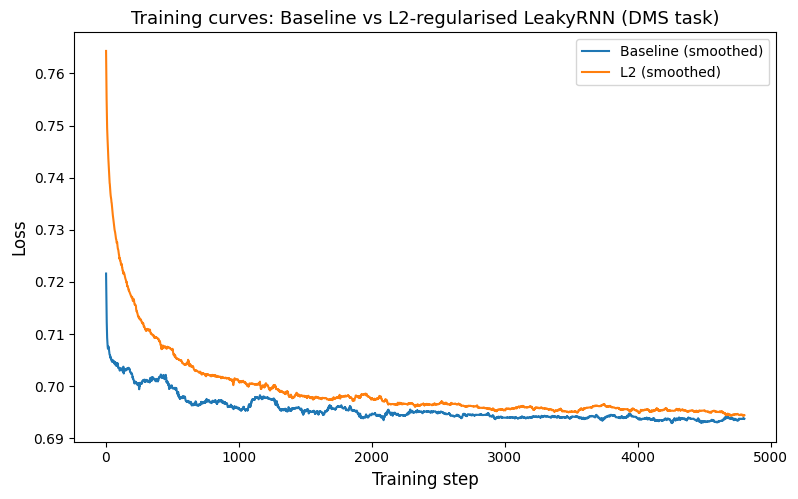

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(base_steps_dms[:len(base_smooth_dms)], base_smooth_dms, label='Baseline (smoothed)')
plt.plot(l2_steps_dms[:len(l2_smooth_dms)],   l2_smooth_dms,   label='L2 (smoothed)')

plt.xlabel("Training step", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.title("Training curves: Baseline vs L2-regularised LeakyRNN (DMS task)",
          fontsize=13)
plt.legend(fontsize=10)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.tight_layout()
plt.show()


In [ ]:
def loss_decomposition_avg(net, dataset, beta_L2, name="model", n_batches=200):
    criterion = nn.CrossEntropyLoss()

    task_losses = []
    reg_terms   = []

    with torch.no_grad():
        for _ in range(n_batches):
            inputs_np, targets_np = dataset()
            inputs  = torch.from_numpy(inputs_np).float()
            targets = torch.from_numpy(targets_np).long()

            outputs, rnn_activity = net(inputs)
            mask = (targets > 0)
            if mask.sum() == 0:
                continue

            outputs_dec = outputs[mask]
            labels_dec  = targets[mask]

            loss_task = criterion(outputs_dec, labels_dec)
            rate_l2   = (rnn_activity**2).sum()
            loss_reg  = beta_L2 * rate_l2

            task_losses.append(float(loss_task))
            reg_terms.append(float(loss_reg))

    mean_task = np.mean(task_losses)
    mean_reg  = np.mean(reg_terms)
    print(f"[{name}] mean task loss over {len(task_losses)} batches: {mean_task:.4f}")
    print(f"[{name}] mean reg term  over {len(reg_terms)} batches: {mean_reg:.4f}")
    print(f"[{name}] reg / task ratio: {mean_reg / mean_task:.4f}")
    print()

beta_L2_dms = 9e-7

loss_decomposition_avg(baseline_net_dms, baseline_dataset_dms,
                       0.0,              "Baseline (DMS)")
loss_decomposition_avg(l2_net_dms,       l2_dataset_dms,
                       beta_L2_dms,      "L2 (DMS)")


[Baseline (DMS)] mean task loss over 200 batches: 0.6933
[Baseline (DMS)] mean reg term  over 200 batches: 0.0000
[Baseline (DMS)] reg / task ratio: 0.0000

[L2 (DMS)] mean task loss over 200 batches: 0.6934
[L2 (DMS)] mean reg term  over 200 batches: 0.0009
[L2 (DMS)] reg / task ratio: 0.0014



In [ ]:


baseline_gt = np.array([info["gt_last"] for info in baseline_trials_dms])
l2_gt       = np.array([info["gt_last"] for info in l2_trials_dms])


baseline_correct = np.array([info["correct"] for info in baseline_trials_dms])
l2_correct       = np.array([info["correct"] for info in l2_trials_dms])

print("Unique baseline labels (DMS):", np.unique(baseline_gt))
print("Unique L2 labels (DMS):",       np.unique(l2_gt))

# In DMS: 0 = fixation, 1 = match, 2 = non-match
match_label    = 1
nonmatch_label = 2

baseline_match_trials     = np.where((baseline_gt == match_label)    & baseline_correct)[0]
baseline_nonmatch_trials  = np.where((baseline_gt == nonmatch_label) & baseline_correct)[0]
l2_match_trials           = np.where((l2_gt == match_label)          & l2_correct)[0]
l2_nonmatch_trials        = np.where((l2_gt == nonmatch_label)       & l2_correct)[0]

print("Baseline DMS correct match trials:",     len(baseline_match_trials))
print("Baseline DMS correct non-match trials:", len(baseline_nonmatch_trials))
print("L2 DMS correct match trials:",           len(l2_match_trials))
print("L2 DMS correct non-match trials:",       len(l2_nonmatch_trials))

def to_numpy(arr):
    if isinstance(arr, torch.Tensor):
        return arr.detach().cpu().numpy()
    return np.asarray(arr)

def stack_activity_dict(activity_dict):
    keys = sorted(activity_dict.keys())
    trial_arrays = [to_numpy(activity_dict[k]) for k in keys]
    data = np.stack(trial_arrays, axis=1)
    return data

baseline_act = stack_activity_dict(baseline_activity_dms)
l2_act       = stack_activity_dict(l2_activity_dms)

T, n_trials, hidden_size = baseline_act.shape
print("DMS activity shape (T, trials, H):", baseline_act.shape)

dt_ms  = getattr(env_dms, "dt", 20.0)
time_s = np.arange(T) * dt_ms / 1000.0


Unique baseline labels (DMS): [1 2]
Unique L2 labels (DMS): [1 2]
Baseline DMS correct match trials: 96
Baseline DMS correct non-match trials: 0
L2 DMS correct match trials: 99
L2 DMS correct non-match trials: 0
DMS activity shape (T, trials, H): (160, 200, 128)


In [ ]:
# confusion matrix analysis
baseline_pred = np.array([info["choice"] for info in baseline_trials_dms])
l2_pred       = np.array([info["choice"] for info in l2_trials_dms])

match_label    = 1
nonmatch_label = 2

valid_mask_base = np.isin(baseline_gt, [match_label, nonmatch_label])
valid_mask_l2   = np.isin(l2_gt,       [match_label, nonmatch_label])

y_true_base = baseline_gt[valid_mask_base]
y_pred_base = baseline_pred[valid_mask_base]

y_true_l2   = l2_gt[valid_mask_l2]
y_pred_l2   = l2_pred[valid_mask_l2]

def print_confusion(name, y_true, y_pred):

    lab2idx = {match_label: 0, nonmatch_label: 1}
    cm = np.zeros((2, 2), dtype=int)
    for t, p in zip(y_true, y_pred):
        cm[lab2idx[t], lab2idx[p]] += 1

    print(f"\nConfusion matrix for {name}:")
    print("               pred match   pred non-match")
    print(f"true match       {cm[0,0]:3d}           {cm[0,1]:3d}")
    print(f"true non-match   {cm[1,0]:3d}           {cm[1,1]:3d}")
    print(f"Total predictions: match = {(cm[:,0]).sum()}, non-match = {(cm[:,1]).sum()}")

print_confusion("Baseline", y_true_base, y_pred_base)
print_confusion("L2",       y_true_l2,   y_pred_l2)


In [ ]:
print("Keys in one trial info dict:")
print(baseline_trials_dms[0].keys())
print("Example contents:")
print(baseline_trials_dms[0])


Keys in one trial info dict:
dict_keys(['trial_index', 'correct', 'choice', 'gt_last'])
Example contents:
{'trial_index': 0, 'correct': False, 'choice': 1, 'gt_last': 2}


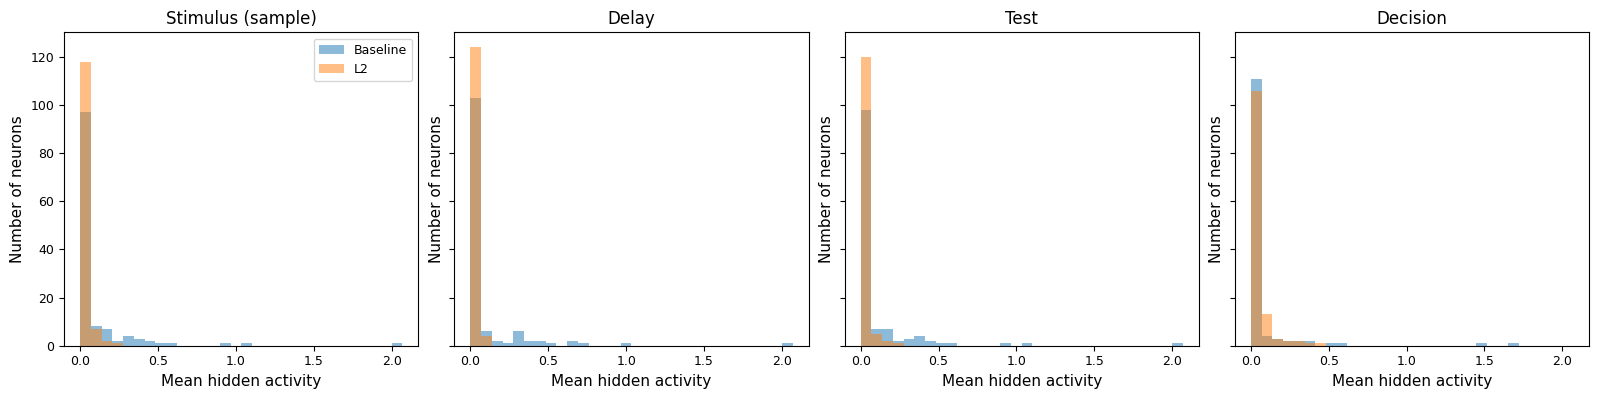

In [ ]:

dt_ms = getattr(env_dms, "dt", 100.0)
timing_dms = env_dms.unwrapped.timing   # {'fixation', 'sample', 'delay', 'test', 'decision'}

def steps_dms(period_name):
    return int(timing_dms[period_name] / dt_ms)

fix_T      = steps_dms('fixation')
sample_T   = steps_dms('sample')
delay_T    = steps_dms('delay')
test_T     = steps_dms('test')
decision_T = steps_dms('decision')

fix_start      = 0
sample_start   = fix_start    + fix_T
delay_start    = sample_start + sample_T
test_start     = delay_start  + delay_T
decision_start = test_start   + test_T

sample_win   = slice(sample_start,   sample_start   + sample_T)
delay_win    = slice(delay_start,    delay_start    + delay_T)
test_win     = slice(test_start,     test_start     + test_T)
decision_win = slice(decision_start, decision_start + decision_T)

def epoch_mean(activity, trial_idx, epoch_slice):
    if len(trial_idx) == 0:
        return np.zeros(activity.shape[2])
    epoch_act = activity[epoch_slice, :, :][:, trial_idx, :]
    return epoch_act.mean(axis=(0, 1))

baseline_corr_trials = np.where(baseline_correct)[0]
l2_corr_trials       = np.where(l2_correct)[0]

baseline_sample_mean = epoch_mean(baseline_act, baseline_corr_trials, sample_win)
l2_sample_mean       = epoch_mean(l2_act,       l2_corr_trials,       sample_win)

baseline_delay_mean = epoch_mean(baseline_act, baseline_corr_trials, delay_win)
l2_delay_mean       = epoch_mean(l2_act,       l2_corr_trials,       delay_win)

baseline_test_mean = epoch_mean(baseline_act, baseline_corr_trials, test_win)
l2_test_mean       = epoch_mean(l2_act,       l2_corr_trials,       test_win)

baseline_dec_mean = epoch_mean(baseline_act, baseline_corr_trials, decision_win)
l2_dec_mean       = epoch_mean(l2_act,       l2_corr_trials,       decision_win)

global_max = max(
    baseline_sample_mean.max(), l2_sample_mean.max(),
    baseline_delay_mean.max(),  l2_delay_mean.max(),
    baseline_test_mean.max(),   l2_test_mean.max(),
    baseline_dec_mean.max(),    l2_dec_mean.max()
)
bin_edges = np.linspace(0, global_max, 31)

fig, axes = plt.subplots(1, 4, figsize=(16, 4), sharey=True, sharex=True)

for ax, base, l2_vals, title in zip(
    axes,
    [baseline_sample_mean, baseline_delay_mean, baseline_test_mean, baseline_dec_mean],
    [l2_sample_mean,       l2_delay_mean,       l2_test_mean,       l2_dec_mean],
    ["Stimulus (sample)", "Delay", "Test", "Decision"],
):
    ax.hist(base,    bins=bin_edges, alpha=0.5, label="Baseline")
    ax.hist(l2_vals, bins=bin_edges, alpha=0.5, label="L2")
    ax.set_title(title, fontsize=12)
    ax.set_xlabel("Mean hidden activity", fontsize=11)
    ax.set_ylabel("Number of neurons", fontsize=11)
    ax.tick_params(axis='both', labelsize=9)

axes[0].legend(fontsize=9)
plt.tight_layout()
plt.show()


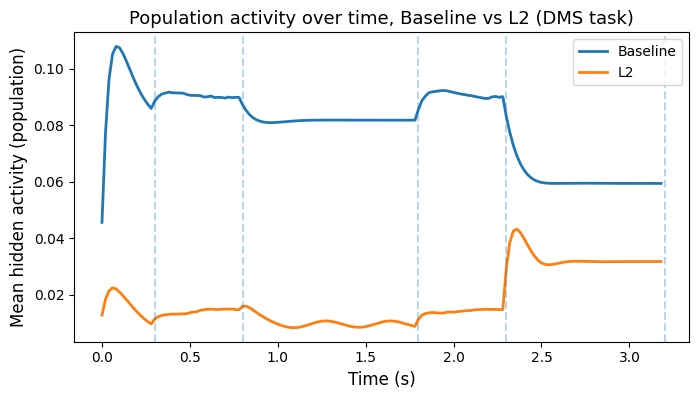

In [ ]:
# Population mean activity over time

T, n_trials, n_hidden = baseline_act.shape

def population_mean_timecourse(activity, correct_mask):

    corr_idx = np.where(correct_mask)[0]
    if len(corr_idx) == 0:
        return np.zeros(activity.shape[0])
    sub = activity[:, corr_idx, :]
    return sub.mean(axis=(1, 2))

baseline_mean_t = population_mean_timecourse(baseline_act, baseline_correct)
l2_mean_t       = population_mean_timecourse(l2_act,       l2_correct)

time_s = np.arange(T) * (dt_ms / 1000.0)

plt.figure(figsize=(7, 4))
plt.plot(time_s, baseline_mean_t, label="Baseline", linewidth=2)
plt.plot(time_s, l2_mean_t,       label="L2",       linewidth=2)

epoch_boundaries = {
    "sample":   sample_start,
    "delay":    delay_start,
    "test":     test_start,
    "decision": decision_start,
}
for name, idx in epoch_boundaries.items():
    t_b = idx * dt_ms / 1000.0
    plt.axvline(t_b, linestyle="--", alpha=0.3)

trial_end = (decision_start + decision_T) * dt_ms / 1000.0
plt.axvline(trial_end, linestyle="--", alpha=0.3)

plt.xlabel("Time (s)", fontsize=12)
plt.ylabel("Mean hidden activity (population)", fontsize=12)
plt.title("Population activity over time, Baseline vs L2 (DMS task)", fontsize=13)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(fontsize=10)

plt.tight_layout()
plt.show()


In [ ]:


baseline_mean_pop_dms = baseline_act.mean(axis=(1, 2))
l2_mean_pop_dms       = l2_act.mean(axis=(1, 2))

ratio_overall_dms = l2_mean_pop_dms.mean() / baseline_mean_pop_dms.mean()
print("Mean pop activity ratio (L2 / baseline, DMS):", ratio_overall_dms)


Mean pop activity ratio (L2 / baseline, DMS): 0.23040733


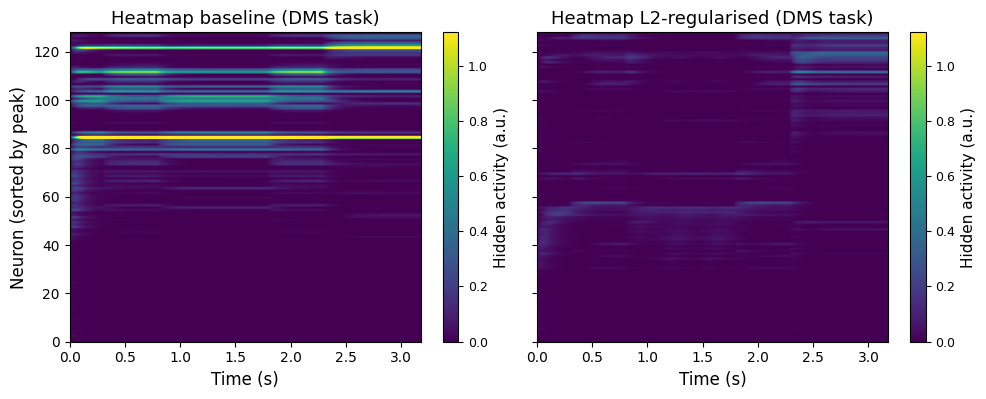

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors

baseline_corr_trials_dms = np.where(baseline_correct)[0]
l2_corr_trials_dms       = np.where(l2_correct)[0]

baseline_mean_dms = baseline_act[:, baseline_corr_trials_dms, :].mean(axis=1)
l2_mean_dms       = l2_act[:,       l2_corr_trials_dms,       :].mean(axis=1)


def sort_by_peak(mean_activity):
    peak_times = mean_activity.argmax(axis=0)
    order      = np.argsort(peak_times)
    sorted_act = mean_activity[:, order].T
    return sorted_act, order

baseline_sorted_dms, base_order_dms = sort_by_peak(baseline_mean_dms)
l2_sorted_dms,       l2_order_dms   = sort_by_peak(l2_mean_dms)

time_s_dms = np.arange(baseline_sorted_dms.shape[1]) * dt_ms / 1000.0

l2_max_dms = float(l2_sorted_dms.max())
vmin_dms   = 0.0
vmax_dms   = 2.0 * l2_max_dms

norm_dms = colors.Normalize(vmin=vmin_dms, vmax=vmax_dms)

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)

im0 = axes[0].imshow(
    baseline_sorted_dms,
    aspect='auto', origin='lower',
    extent=[time_s_dms[0], time_s_dms[-1], 0, baseline_sorted_dms.shape[0]],
    norm=norm_dms
)
axes[0].set_title("Heatmap baseline (DMS task)", fontsize=13)
axes[0].set_xlabel("Time (s)", fontsize=12)
axes[0].set_ylabel("Neuron (sorted by peak)", fontsize=12)
axes[0].tick_params(axis='both', labelsize=10)

cbar0 = plt.colorbar(im0, ax=axes[0])
cbar0.set_label("Hidden activity (a.u.)", fontsize=11)
cbar0.ax.tick_params(labelsize=9)

im1 = axes[1].imshow(
    l2_sorted_dms,
    aspect='auto', origin='lower',
    extent=[time_s_dms[0], time_s_dms[-1], 0, l2_sorted_dms.shape[0]],
    norm=norm_dms
)
axes[1].set_title("Heatmap L2-regularised (DMS task)", fontsize=13)
axes[1].set_xlabel("Time (s)", fontsize=12)
axes[1].tick_params(axis='both', labelsize=10)

cbar1 = plt.colorbar(im1, ax=axes[1])
cbar1.set_label("Hidden activity (a.u.)", fontsize=11)
cbar1.ax.tick_params(labelsize=9)

plt.tight_layout()
plt.show()


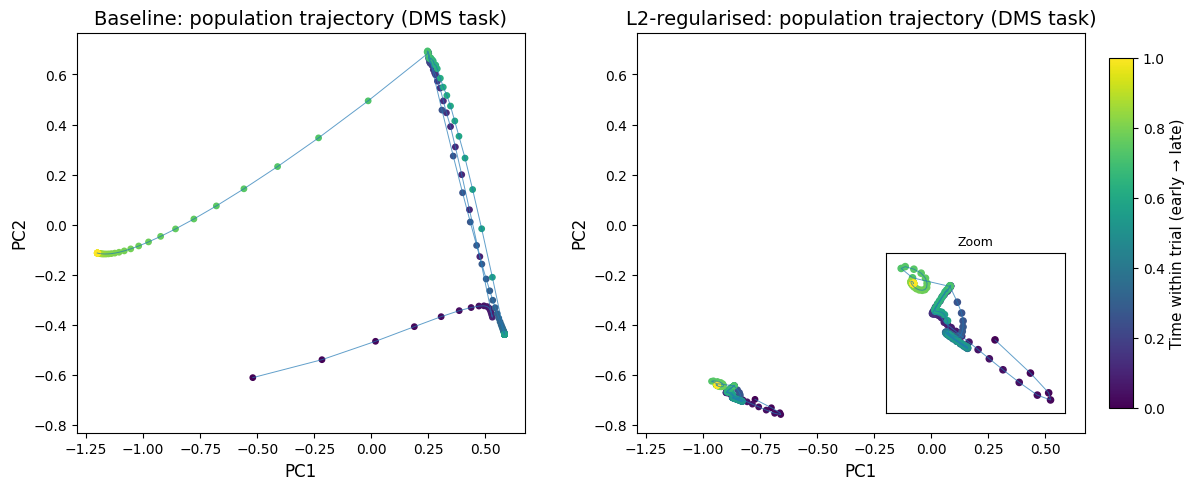

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

baseline_corr_trials_dms = np.where(baseline_correct)[0]
l2_corr_trials_dms       = np.where(l2_correct)[0]

baseline_mean_dms = baseline_act[:, baseline_corr_trials_dms, :].mean(axis=1)
l2_mean_dms       = l2_act[:,       l2_corr_trials_dms,       :].mean(axis=1)

T_dms = baseline_mean_dms.shape[0]
dt = 0.02
time_s_dms = np.arange(T_dms) * dt
time_norm = (time_s_dms - time_s_dms.min()) / (time_s_dms.max() - time_s_dms.min())

pca = PCA(n_components=2)
baseline_pc_dms = pca.fit_transform(baseline_mean_dms)
l2_pc_dms       = pca.transform(l2_mean_dms)

all_pc_dms = np.vstack([baseline_pc_dms, l2_pc_dms])

xmin, xmax = all_pc_dms[:, 0].min(), all_pc_dms[:, 0].max()
ymin, ymax = all_pc_dms[:, 1].min(), all_pc_dms[:, 1].max()

x_margin = 0.05 * (xmax - xmin)
y_margin = 0.05 * (ymax - ymin)

xlim = (xmin - x_margin, xmax + x_margin)
ylim = (ymin - y_margin, ymax + y_margin)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
ax1, ax2 = axes

sc1 = ax1.scatter(
    baseline_pc_dms[:, 0], baseline_pc_dms[:, 1],
    c=time_norm, cmap='viridis', s=15
)
ax1.plot(
    baseline_pc_dms[:, 0], baseline_pc_dms[:, 1],
    linewidth=0.7, alpha=0.7
)
ax1.set_title("Baseline: population trajectory (DMS task)", fontsize=14)
ax1.set_xlabel("PC1", fontsize=12)
ax1.set_ylabel("PC2", fontsize=12)
ax1.set_xlim(xlim); ax1.set_ylim(ylim)
ax1.tick_params(axis='both', labelsize=10)

sc2 = ax2.scatter(
    l2_pc_dms[:, 0], l2_pc_dms[:, 1],
    c=time_norm, cmap='viridis', s=15
)
ax2.plot(
    l2_pc_dms[:, 0], l2_pc_dms[:, 1],
    linewidth=0.7, alpha=0.7
)
ax2.set_title("L2-regularised: population trajectory (DMS task)", fontsize=14)
ax2.set_xlabel("PC1", fontsize=12)
ax2.set_ylabel("PC2", fontsize=12)
ax2.set_xlim(xlim); ax2.set_ylim(ylim)
ax2.tick_params(axis='both', labelsize=10)

axins = inset_axes(
    ax2,
    width="40%", height="40%",
    loc="lower right",
    borderpad=2.0,
)

axins.scatter(l2_pc_dms[:, 0], l2_pc_dms[:, 1],
              c=time_norm, cmap='viridis', s=20)
axins.plot(l2_pc_dms[:, 0], l2_pc_dms[:, 1],
           linewidth=0.7, alpha=0.7)

x_min, x_max = l2_pc_dms[:, 0].min(), l2_pc_dms[:, 0].max()
y_min, y_max = l2_pc_dms[:, 1].min(), l2_pc_dms[:, 1].max()
x_pad = 0.1 * (x_max - x_min)
y_pad = 0.1 * (y_max - y_min)

axins.set_xlim(x_min - x_pad, x_max + x_pad)
axins.set_ylim(y_min - y_pad, y_max + y_pad)
axins.set_xticks([])
axins.set_yticks([])
axins.set_title("Zoom", fontsize=9)

fig.subplots_adjust(left=0.06, right=0.9, bottom=0.1, top=0.9, wspace=0.25)

cax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
cbar = fig.colorbar(sc2, cax=cax)
cbar.set_label("Time within trial (early \N{RIGHTWARDS ARROW} late)", fontsize=11)
cbar.ax.tick_params(labelsize=10)

plt.show()
